CSCI 184 Project

Lauren Vu, Christopher Phan, and Danny Lin
1. We examine the dataset by by converting it into a Pandas dataframe. The collection of datasets we downloaded included an unbalanced version and a balanced version, so we decide to use the pre-balanced version for training and testing.

In [ ]:
#!pip install scikeras

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

#from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

csv_path = 'diabetes_balanced.csv'
data = pd.read_csv(csv_path)
print(data)
print("diabetes.csv shape: ",data.shape);

       Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                  0.0     1.0       0.0        1.0  26.0     0.0     0.0   
1                  0.0     1.0       1.0        1.0  26.0     1.0     1.0   
2                  0.0     0.0       0.0        1.0  26.0     0.0     0.0   
3                  0.0     1.0       1.0        1.0  28.0     1.0     0.0   
4                  0.0     0.0       0.0        1.0  29.0     1.0     0.0   
...                ...     ...       ...        ...   ...     ...     ...   
70687              1.0     0.0       1.0        1.0  37.0     0.0     0.0   
70688              1.0     0.0       1.0        1.0  29.0     1.0     0.0   
70689              1.0     1.0       1.0        1.0  25.0     0.0     0.0   
70690              1.0     1.0       1.0        1.0  18.0     0.0     0.0   
70691              1.0     1.0       1.0        1.0  25.0     0.0     0.0   

       HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0 

2. We examine the columns and column types in order to decide which classifier to use. Upon observation, they are all numerical variables. Our target variable is diabetes, which is a binary numerical attribute (0 for no diabetes, 1 for diabetes). HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, DiffWalk, are also binary numerical attribute.

In [ ]:
column_names_list = list(data.columns)
for cName in column_names_list:
        col_type = data[cName].dtype
        print("column name: ", cName, ", column type: ", col_type, ", Unique values: ")
        for item in data[cName].unique():
            print(item)

column name:  Diabetes_binary , column type:  float64 , Unique values: 
0.0
1.0
column name:  HighBP , column type:  float64 , Unique values: 
1.0
0.0
column name:  HighChol , column type:  float64 , Unique values: 
0.0
1.0
column name:  CholCheck , column type:  float64 , Unique values: 
1.0
0.0
column name:  BMI , column type:  float64 , Unique values: 
26.0
28.0
29.0
18.0
31.0
32.0
27.0
24.0
21.0
58.0
30.0
20.0
22.0
38.0
40.0
25.0
36.0
47.0
19.0
37.0
41.0
23.0
34.0
35.0
42.0
17.0
33.0
44.0
15.0
52.0
69.0
56.0
45.0
39.0
92.0
53.0
98.0
50.0
46.0
79.0
48.0
16.0
63.0
72.0
54.0
49.0
68.0
43.0
84.0
73.0
76.0
55.0
51.0
75.0
57.0
60.0
12.0
77.0
82.0
67.0
71.0
61.0
14.0
81.0
59.0
86.0
13.0
87.0
65.0
95.0
89.0
62.0
64.0
66.0
85.0
70.0
83.0
80.0
78.0
74.0
column name:  Smoker , column type:  float64 , Unique values: 
0.0
1.0
column name:  Stroke , column type:  float64 , Unique values: 
0.0
1.0
column name:  HeartDiseaseorAttack , column type:  float64 , Unique values: 
0.0
1.0
column name:  P

In [ ]:
from scipy import stats
import numpy as np

features_to_remove = []
balance_factor = 4

# chi-square tests between Diabetes_binary and binary input features
for attribute in data.columns:
  if (attribute != "Diabetes_binary" and data[attribute].nunique() == 2):
    contingency = pd.crosstab(data["Diabetes_binary"], data[attribute])
    r, c = contingency.shape

    # display contingency table along with chi-square value and degrees of freedom
    print("Chi-square contingency table between Diabetes_binary and " + attribute + ":")
    print(contingency)
    print("Chi-square = " + str(stats.chi2_contingency(contingency).statistic))
    print("df = " + str((r - 1) * (c - 1)))

    # compute 99% confidence intervals for the following probabilities:
    # P(Diabetes positive | attribute = true)
    attribute_true = contingency.loc[0, 1] + contingency.loc[1, 1]
    diabetes_pos = contingency.loc[1, 1]
    p_hat = diabetes_pos/attribute_true
    error = 2.575 * np.sqrt(p_hat * (1 - p_hat) / attribute_true)
    print("99% Confidence Intervals for:")
    print("P(Diabetes positive | " + attribute + " = true): " + str(round(p_hat, 4)) + " +/- " + str(round(error, 4)))

    # P(Diabetes positive | attribute = false)
    attribute_false = contingency.loc[0, 0] + contingency.loc[1, 0]
    diabetes_neg = contingency.loc[1, 0]
    p_hat = diabetes_neg/attribute_false
    error = 2.575 * np.sqrt(p_hat * (1 - p_hat) / attribute_false)
    print("P(Diabetes positive | " + attribute + " = false): " + str(round(p_hat, 4)) + " +/- " + str(round(error, 4)))

    print("Examples with " + attribute + " = true: " + str(attribute_true))
    print("Examples with " + attribute + " = false: " + str(attribute_false) + "\n")

    # if dataset is largely unbalanced with respect to attribute
    if (abs(np.log(attribute_true/attribute_false)) > abs(np.log(balance_factor))):
      features_to_remove.append(attribute)

print("Highly unbalanced features: " + str(features_to_remove))

data = data.drop(columns=features_to_remove)
data

Chi-square contingency table between Diabetes_binary and HighBP:
HighBP             0.0    1.0
Diabetes_binary              
0.0              22118  13228
1.0               8742  26604
Chi-square = 10287.972984997781
df = 1
99% Confidence Intervals for:
P(Diabetes positive | HighBP = true): 0.6679 +/- 0.0061
P(Diabetes positive | HighBP = false): 0.2833 +/- 0.0066
Examples with HighBP = true: 39832
Examples with HighBP = false: 30860

Chi-square contingency table between Diabetes_binary and HighChol:
HighChol           0.0    1.0
Diabetes_binary              
0.0              21869  13477
1.0              11660  23686
Chi-square = 5911.8066998822505
df = 1
99% Confidence Intervals for:
P(Diabetes positive | HighChol = true): 0.6374 +/- 0.0064
P(Diabetes positive | HighChol = false): 0.3478 +/- 0.0067
Examples with HighChol = true: 37163
Examples with HighChol = false: 33529

Chi-square contingency table between Diabetes_binary and CholCheck:
CholCheck         0.0    1.0
Diabetes_binary

,Diabetes_binary,HighBP,HighChol,BMI,Smoker,PhysActivity,Fruits,Veggies,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,26.0,0.0,1.0,0.0,1.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,26.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,26.0,0.0,1.0,1.0,1.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,28.0,1.0,1.0,1.0,1.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,29.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,37.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


3. We split the dataset into test and train portions, 70% train and 30% test, then train a decision tree using Sklearn and test it, reporting results back as a confusion matrix.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y = data.iloc[:,0]
X = data.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

Confusion Matrix using Sklearn Decision Tree, Depth: 3
Precision 0.6720214190093708
Recall: 0.850687252871399
Accuracy 0.7172764994341758
F1-Score 0.7508725278377929


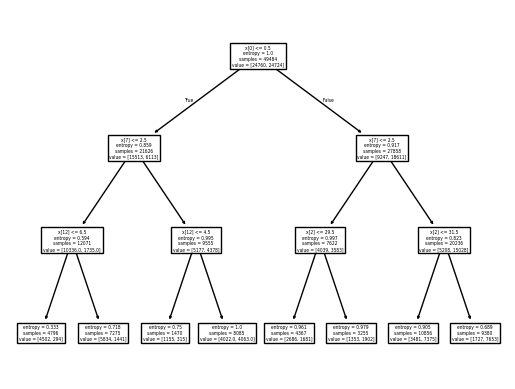

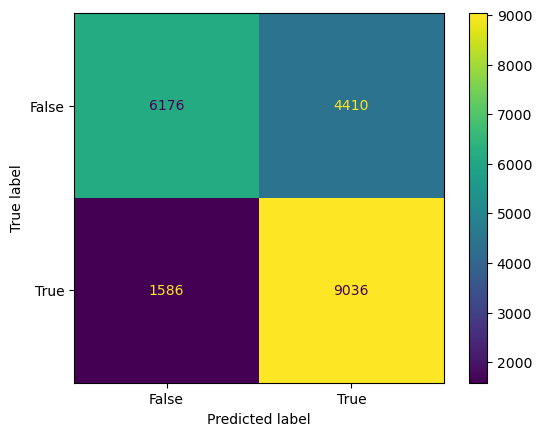

In [ ]:
#depth of 3
cls3 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)
# train classifier
cls3.fit(X_train, y_train)
#print out tree
tree.plot_tree(cls3)
#predict target variable
y_predict = cls3.predict(X_test)

cnmatrix = metrics.confusion_matrix(y_test,y_predict)
cnmatrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnmatrix, display_labels = [False, True])
print("Confusion Matrix using Sklearn Decision Tree, Depth: 3")
cnmatrix_display.plot()

print("Precision",precision_score(y_test,y_predict))
print("Recall:", recall_score(y_test,y_predict))
print("Accuracy", accuracy_score(y_test,y_predict))
print("F1-Score", f1_score(y_test,y_predict))

Confusion Matrix using Sklearn Decision Tree, Depth: 5
Precision 0.7163727524204703
Recall: 0.7801732253812841
Accuracy 0.7351942663145983
F1-Score 0.7469130238846328


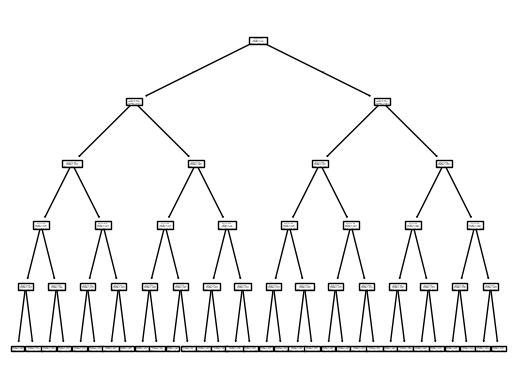

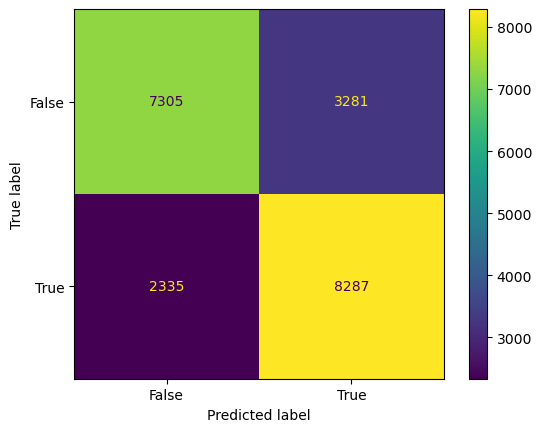

In [ ]:
#depth of 5
cls5 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 5)
#train the tree classifier
cls5.fit(X_train, y_train)
#print out the tree
tree.plot_tree(cls5)
#predict target of test set
y_predict = cls5.predict(X_test)

cnmatrix = metrics.confusion_matrix(y_test,y_predict)
cnmatrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnmatrix, display_labels = [False, True])
print("Confusion Matrix using Sklearn Decision Tree, Depth: 5")
cnmatrix_display.plot()

print("Precision",precision_score(y_test,y_predict))
print("Recall:", recall_score(y_test,y_predict))
print("Accuracy", accuracy_score(y_test,y_predict))
print("F1-Score", f1_score(y_test,y_predict))

       Diabetes_binary  HighBP  HighChol   BMI  Smoker  PhysActivity  Fruits  \
0                  0.0     1.0       0.0  26.0     0.0           1.0     0.0   
1                  0.0     1.0       1.0  26.0     1.0           0.0     1.0   
2                  0.0     0.0       0.0  26.0     0.0           1.0     1.0   
3                  0.0     1.0       1.0  28.0     1.0           1.0     1.0   
4                  0.0     0.0       0.0  29.0     1.0           1.0     1.0   
...                ...     ...       ...   ...     ...           ...     ...   
70687              1.0     0.0       1.0  37.0     0.0           0.0     0.0   
70688              1.0     0.0       1.0  29.0     1.0           0.0     1.0   
70689              1.0     1.0       1.0  25.0     0.0           0.0     1.0   
70690              1.0     1.0       1.0  18.0     0.0           0.0     0.0   
70691              1.0     1.0       1.0  25.0     0.0           1.0     1.0   

       Veggies  GenHlth  MentHlth  Phys

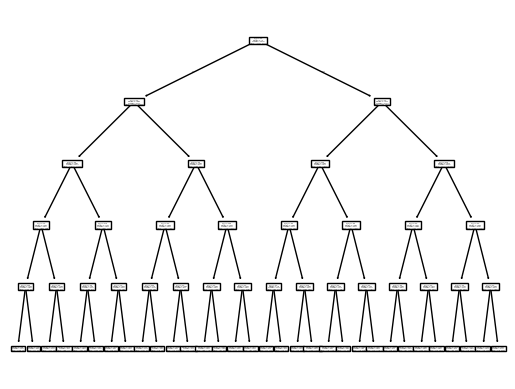

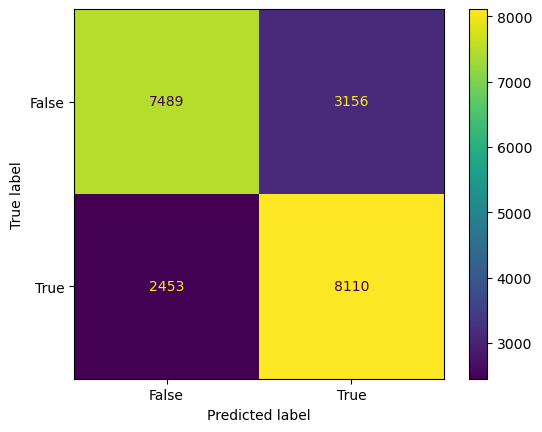

In [ ]:
#depth of 5
cls5 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 5)
X = data[["HighBP","HighChol","BMI","Smoker","GenHlth", "PhysHlth","PhysActivity","DiffWalk", "Income", "Education", "Age"]]
Y = data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
#train the tree classifier
cls5.fit(X_train, y_train)
#print out the tree
tree.plot_tree(cls5)
#predict target of test set
y_predict = cls5.predict(X_test)
yTrain_pred = cls5.predict(X_train)

cnmatrix = metrics.confusion_matrix(y_test,y_predict)
cnmatrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnmatrix, display_labels = [False, True])
print("Confusion Matrix using Sklearn Decision Tree with Feature Selection, Depth: 5")
cnmatrix_display.plot()

print("Precision",precision_score(y_test,y_predict))
print("Recall:", recall_score(y_test,y_predict))
print("Accuracy", accuracy_score(y_test,y_predict))
print("F1-Score", f1_score(y_test,y_predict))

print("Train Acc: ", accuracy_score(y_train, yTrain_pred))

In [ ]:
#depth of 15
cls5 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 15)
X = data[["HighBP","HighChol","BMI","Smoker","GenHlth", "PhysHlth","PhysActivity","DiffWalk", "Income", "Education", "Age"]]
Y = data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
#train the tree classifier
cls5.fit(X_train, y_train)
#print out the tree
# tree.plot_tree(cls5)  # this line slows down this block of code by several minutes, which is why it's commented out
#predict target of test set
y_predict = cls5.predict(X_test)
yTrain_pred = cls5.predict(X_train)

cnmatrix = metrics.confusion_matrix(y_test,y_predict)
cnmatrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnmatrix, display_labels = [False, True])
print("Confusion Matrix using Sklearn Decision Tree with Feature Selection, Depth: 15")
cnmatrix_display.plot()

print("Precision",precision_score(y_test,y_predict))
print("Recall:", recall_score(y_test,y_predict))
print("Accuracy", accuracy_score(y_test,y_predict))
print("F1-Score", f1_score(y_test,y_predict))

print("Train Acc: ", accuracy_score(y_train, yTrain_pred))

Confusion Matrix using Sklearn Decision Tree with Feature Selection, Depth: 15
Precision 0.7010422380691168
Recall: 0.7154987403191192
Accuracy 0.7020463975858167
F1-Score 0.7081967213114754
Train Acc:  0.8392005496726215
Error in callback <function flush_figures at 0x0000026CED39E200> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Depth of 5 had a decrease in F1 Score. Depth 3 is best for now. We now examine which features were most relevant in determining the target variable in the decision tree. x[0] (HighBP) was most relevant, followed by x[13] (GenHlth). Next considered were x[15] (PhysHlth) and x[3] (BMI). From this we can conclude that HighBP and BMI have some effect on whether a person is diagnosed with diabetes.

We try a Naive Bayes Classifier to see if we can get any improvements in performance. We have continuous variables and binary discrete variables. We use CategorialNB

In [ ]:
# categorical Naive Bayes
from sklearn.naive_bayes import CategoricalNB
from matplotlib import pyplot as plt

# split the data again into training and test data
Y = data.iloc[:,0]
X = data.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# train categorical Naive Bayes classifier
clf = CategoricalNB()
clf.fit(X_train, y_train)

# predict target variables
y_predict = clf.predict(X_test)

# compute and display confusion matrix
cnmatrix = metrics.confusion_matrix(y_test,y_predict)
cnmatrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnmatrix, display_labels = [False, True])
print("Confusion Matrix using Sklearn Categorical Naive Bayes")
cnmatrix_display.plot()

# print performance metrics
print("Precision: ",precision_score(y_test,y_predict))
print("Recall: ", recall_score(y_test,y_predict))
print("Accuracy: ", accuracy_score(y_test,y_predict))
print("F1-Score: ", f1_score(y_test,y_predict))

XGBoost Section

In [ ]:
import xgboost as xgb
from sklearn import metrics
#xgb_cls = xgb.XGBClassifier(learning_rate = 0.1,max_depth = 5, n_estimators = 10)
xgb_cls = xgb.XGBClassifier(learning_rate = 0.1,max_depth = 3, n_estimators = 500)
xgb_cls.fit(X_train,y_train)
y_predict = xgb_cls.predict(X_test)

cnmatrix = metrics.confusion_matrix(y_test,y_predict)
cnmatrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnmatrix, display_labels = [False, True])
print("Confusion Matrix for XGBoost Classfifier")
cnmatrix_display.plot()

print("Precision",precision_score(y_test,y_predict))
print("Recall:", recall_score(y_test,y_predict))
print("Accuracy", accuracy_score(y_test,y_predict))
print("F1-Score", f1_score(y_test,y_predict))

To see if we can predict Diabetes more effectively, we train a neural network on the training split:

In [ ]:
# Neural networks (3-layer)
# Note: this code block takes a long time to run (around 45 minutes). Feel free
# to let this run in the background and do other things in the mean time
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import Input
from keras.backend import clear_session
from keras.metrics import Precision, Recall, BinaryAccuracy, F1Score

# split data into train and test data
Y = data.iloc[:,0]
X = data.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# optimizers
opt_names = ["SGD", "Adam", "RMSProp"]

# F1 scores are recorded here
# column 0 = SGD, column 1 = Adam, column 2 = RMSProp
f1_scores = np.zeros((10, 3))

# train shallow neural networks
for num_epochs in range(5, 55, 5):
    for i in range(3):
        model = Sequential()
        model.add(Dense(12, activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        if (i == 0):
            opt = optimizers.SGD(learning_rate=0.01)
        elif (i == 1):
            opt = optimizers.Adam(learning_rate=0.001)
        else:
            opt = optimizers.RMSprop(learning_rate=0.001)

        # metrics classes
        precision = Precision(thresholds=0.5)
        recall = Recall(thresholds=0.5)
        accuracy = BinaryAccuracy(threshold=0.5)
        f1score = F1Score(threshold=0.5)

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics = [precision, recall, accuracy, f1score])
        model.fit(X_train, y_train, epochs=num_epochs, verbose=0)

        print("Finished training with optimizer " + opt_names[i] + " and epochs = " + str(num_epochs))

        # evaluate model and print performance metrics
        metrics = model.evaluate(X_test, y_test, verbose=0)

        print("Performance metrics for 3-layer neural network with " + opt_names[i] + " and " + str(num_epochs) + " epochs")
        print("Precision: ", metrics[1])
        print("Recall: ", metrics[2])
        print("Accuracy: ", metrics[3])

        j = int(num_epochs/5 - 1)
        # record F1 score
        f1_scores[j, i] = metrics[4]

        print("F1-Score: ", f1_scores[j, i])

        clear_session()
        print("\n")

plt.plot(np.linspace(5, 50, 10), f1_scores)
plt.legend(opt_names)

In [ ]:
# Deep neural network

# Note: this code block takes a long time to run (around 40 minutes). Feel free
# to let this run in the background and do other things in the mean time

# split data into train and test data
Y = data.iloc[:,0]
X = data.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# F1 scores are recorded here
f1_scores_deep = np.zeros(10)

for num_epochs in range(10, 110, 10):
    # train deep neural network

    # initialize model
    model = Sequential()

    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # initialize RMSprop optimizer
    opt = optimizers.RMSprop(learning_rate=0.001)

    # metrics classes
    precision = Precision(thresholds=0.5)
    recall = Recall(thresholds=0.5)
    accuracy = BinaryAccuracy(threshold=0.5)
    f1score = F1Score(threshold=0.5)

    # compile and train deep NN
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics = [precision, recall, accuracy, f1score])
    model.fit(X_train, y_train, epochs=num_epochs, verbose=0)

    # evaluate model and print performance metrics
    metrics = model.evaluate(X_test, y_test, verbose=0)

    print("Performance metrics for 11-layer neural network with RMSprop optimizer and " + str(num_epochs) + " epochs")
    print("Precision: ", metrics[1])
    print("Recall: ", metrics[2])
    print("Accuracy: ", metrics[3])

    # record F1 score
    j = int(num_epochs/10 - 1)
    f1_scores_deep[j] = metrics[4]
    print("F1-Score: ", f1_scores_deep[j])

    clear_session()
    print("\n")

plt.plot(np.linspace(10, 100, 10), f1_scores_deep)
plt.title("F1-Score vs. Number of Epochs (11-layer NN))")